In [4]:
#exportamos a html
import os 
os.system('jupyter nbconvert --to html modelo_bajas_v3.ipynb')

0

# Modelo Bajas

### Variables utilizadas <br>
#### Indicadores
NIA <br>
VC_CURSACAD_INI <br>
DT_BAJA <br>
CURSACAD_BAJA <br>
#### Resultados académicos primer año
NOTA_1 : Nota media del primer año <br>
NOTA GENETICA <br>
NOTA ANATOMIA <br>
NOTA BIOQUIMICA <br>
NOTA ESTADÍSTICA <br>
NOTA INMUNOLOGÍA <br>
NB_REC_CURSO <br>
NB_SUP_CURSO <br>
NB_MAT_CURSO <br>
#### Perfil alumno
NB_NOTAESTUDIOS <br>
NB_NOTA_1BACHI <br>
NB_NOTA_PSIC   <br>
NOTA_INGLES <br>
NB_NOTA_ESPECIFICA <br>
SEXO <br>
NACIONALIDAD <br>
CODPROV_HAB <br>
ACCESO
#### Feature engineering
CRÉDITOS SUSPENDIDOS <br>
EDAD

Carga de paquetes y librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cx_Oracle

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)

### Ingesta de datos

Procedemos a la carga de datos utilizando los datos almacenados en nuestros servidores de Oracle. <br>
Disponemos de observaciones desde 2019 hasta 2022

In [5]:
#conexión Oracle
DB_USER = os.getenv('DB_USER')
DB_PASSWORD= os.getenv('DB_PASSWORD')
DB_DNS = os.getenv('DB_DNS')

dsn_tns = cx_Oracle.makedsn('data01.uax.es', '1521', service_name='orcl')
conn = cx_Oracle.connect(user=DB_USER, password=DB_PASSWORD, dsn=DB_DNS) 

In [33]:
#query datos de entrenamiento
c = conn.cursor()
query = c.execute('''
select * from (
select distinct a.nia, a.vc_cursacad_ini, a.dt_baja , cursacad_baja, dsc.nota_1, gen.nota_genetica, ana.nota_anatomia, bio.nota_bioquimica, esta.nota_estadistica, inmu.nota_inmunologia, etica.nota_bioetica,
nb_notaestudios, nb_em_nota_1bachi, nb_nota_psicotecnico,nb_nota_idioma_ing, nb_nota_especifica,NB_EM_NOTA_PAU, sexo, nacionalidad, vc_codprov_hab, acceso, f_nacimiento, dsc.nb_rec_curso, dsc.nb_sup_curso, dsc.nb_mat_curso
from dv_perfil_alumno a
    left join (
        select nia, vc_cursacad, nota_media_curso_ss nota_1, nb_rec_curso, nb_sup_curso, nb_mat_curso
            from ds_resumen_creditos
            ) dsc on dsc.nia = a.nia and dsc.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_genetica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130105'
        order by 1
        ) gen on gen.nia = a.nia and gen.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_anatomia
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130101'
        order by 1
        ) ana on ana.nia = a.nia and ana.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_bioquimica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130103'
        order by 1
        ) bio on bio.nia = a.nia and bio.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_estadistica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130104'
        order by 1
        ) esta on esta.nia = a.nia and esta.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_inmunologia
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130109'
        order by 1
        ) inmu on inmu.nia = a.nia and inmu.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_bioetica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130106'
        order by 1
        ) etica on etica.nia = a.nia and etica.vc_cursacad = a.vc_cursacad_ini
where a.vc_cursacad_ini >= 2019 and a.vc_cursacad_ini <2022 and a.vc_codcarr = 'GME' and (to_number(to_char(a.dt_baja, 'YYYY')) <> a.vc_cursacad or dt_baja is null)
order by 2,1,4
 ) sub1 order by 3 asc
 ''')

df = pd.DataFrame(c.fetchall(), columns = [i[0] for i in c.description])

In [34]:
df.info(verbose = True, show_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   NIA                   533 non-null    object        
 1   VC_CURSACAD_INI       533 non-null    object        
 2   DT_BAJA               24 non-null     datetime64[ns]
 3   CURSACAD_BAJA         24 non-null     object        
 4   NOTA_1                533 non-null    float64       
 5   NOTA_GENETICA         511 non-null    float64       
 6   NOTA_ANATOMIA         508 non-null    float64       
 7   NOTA_BIOQUIMICA       511 non-null    float64       
 8   NOTA_ESTADISTICA      511 non-null    float64       
 9   NOTA_INMUNOLOGIA      508 non-null    float64       
 10  NOTA_BIOETICA         508 non-null    float64       
 11  NB_NOTAESTUDIOS       465 non-null    float64       
 12  NB_EM_NOTA_1BACHI     285 non-null    float64       
 13  NB_NOTA_PSICOTECNICO

In [35]:
print(f'El  original data set tiene la siguiente forma:  {df.shape[0]} filas y {df.shape[1]} columnas')

El  original data set tiene la siguiente forma:  533 filas y 25 columnas


In [36]:
df.head()

,NIA,VC_CURSACAD_INI,DT_BAJA,CURSACAD_BAJA,NOTA_1,NOTA_GENETICA,NOTA_ANATOMIA,NOTA_BIOQUIMICA,NOTA_ESTADISTICA,NOTA_INMUNOLOGIA,NOTA_BIOETICA,NB_NOTAESTUDIOS,NB_EM_NOTA_1BACHI,NB_NOTA_PSICOTECNICO,NB_NOTA_IDIOMA_ING,NB_NOTA_ESPECIFICA,NB_EM_NOTA_PAU,SEXO,NACIONALIDAD,VC_CODPROV_HAB,ACCESO,F_NACIMIENTO,NB_REC_CURSO,NB_SUP_CURSO,NB_MAT_CURSO
0,635818,2019,2020-01-08,2019,0.000,NaN,NaN,NaN,NaN,NaN,NaN,5.55,NaN,NaN,NaN,NaN,NaN,M,E,50,2º Bachillerato,2000-08-16,0.0,0.0,60.0
1,640440,2019,2020-10-20,2020,6.773,5.0,7.5,5.7,5.9,6.0,8.8,7.71,NaN,7.0,7.33,6.00,NaN,H,E,30,2º Bachillerato,2001-11-19,0.0,60.0,60.0
2,645603,2019,2020-10-22,2020,8.902,8.0,9.7,8.1,7.7,9.0,8.8,NaN,NaN,5.6,NaN,NaN,NaN,M,E,49,Titulado,1996-03-29,7.0,59.0,59.0
3,640402,2019,2020-11-25,2020,4.620,5.0,0.1,6.7,5.8,4.3,5.0,6.81,NaN,7.0,10.00,6.86,NaN,H,E,50,2º Bachillerato,2001-04-22,0.0,40.0,60.0
4,648781,2020,2021-01-18,2020,0.000,NaN,NaN,NaN,NaN,NaN,NaN,9.59,9.88,5.4,8.00,8.29,NaN,H,E,28,2º Bachillerato,2002-12-03,0.0,0.0,60.0


### Ánalisis exploratorio de datos

In [37]:
#observamos las bajas marcadas por la fecha en que se van
df[df['DT_BAJA'].notna()].head(5)

,NIA,VC_CURSACAD_INI,DT_BAJA,CURSACAD_BAJA,NOTA_1,NOTA_GENETICA,NOTA_ANATOMIA,NOTA_BIOQUIMICA,NOTA_ESTADISTICA,NOTA_INMUNOLOGIA,NOTA_BIOETICA,NB_NOTAESTUDIOS,NB_EM_NOTA_1BACHI,NB_NOTA_PSICOTECNICO,NB_NOTA_IDIOMA_ING,NB_NOTA_ESPECIFICA,NB_EM_NOTA_PAU,SEXO,NACIONALIDAD,VC_CODPROV_HAB,ACCESO,F_NACIMIENTO,NB_REC_CURSO,NB_SUP_CURSO,NB_MAT_CURSO
0,635818,2019,2020-01-08,2019,0.000,NaN,NaN,NaN,NaN,NaN,NaN,5.55,NaN,NaN,NaN,NaN,NaN,M,E,50,2º Bachillerato,2000-08-16,0.0,0.0,60.0
1,640440,2019,2020-10-20,2020,6.773,5.0,7.5,5.7,5.9,6.0,8.8,7.71,NaN,7.0,7.33,6.00,NaN,H,E,30,2º Bachillerato,2001-11-19,0.0,60.0,60.0
2,645603,2019,2020-10-22,2020,8.902,8.0,9.7,8.1,7.7,9.0,8.8,NaN,NaN,5.6,NaN,NaN,NaN,M,E,49,Titulado,1996-03-29,7.0,59.0,59.0
3,640402,2019,2020-11-25,2020,4.620,5.0,0.1,6.7,5.8,4.3,5.0,6.81,NaN,7.0,10.00,6.86,NaN,H,E,50,2º Bachillerato,2001-04-22,0.0,40.0,60.0
4,648781,2020,2021-01-18,2020,0.000,NaN,NaN,NaN,NaN,NaN,NaN,9.59,9.88,5.4,8.00,8.29,NaN,H,E,28,2º Bachillerato,2002-12-03,0.0,0.0,60.0


In [38]:
#create target variable
df['baja'] = np.where(df['DT_BAJA'].isna(), 0, 1)
df['baja'] = np.where(df['DT_BAJA'].isna(), 0, 1)

In [39]:
def check_duplicates(data):
    data_dub = data.copy()
    data = data[~data.index.duplicated(keep='first')]
    print('   original      copia \n',
    data.shape, str('|'), data_dub.shape)

check_duplicates(df)

   original      copia 
 (533, 26) | (533, 26)


Podemos ver que no hay duplicados en el dataset

### Nos centramos en los missings ya que a primera vista parece que hay una cantidad considerable de missings en algunas variables

In [40]:
round(100*(df.isnull().sum()/len(df.index)), 2).head(50)

NIA                      0.00
VC_CURSACAD_INI          0.00
DT_BAJA                 95.50
CURSACAD_BAJA           95.50
NOTA_1                   0.00
NOTA_GENETICA            4.13
NOTA_ANATOMIA            4.69
NOTA_BIOQUIMICA          4.13
NOTA_ESTADISTICA         4.13
NOTA_INMUNOLOGIA         4.69
NOTA_BIOETICA            4.69
NB_NOTAESTUDIOS         12.76
NB_EM_NOTA_1BACHI       46.53
NB_NOTA_PSICOTECNICO    15.38
NB_NOTA_IDIOMA_ING      24.20
NB_NOTA_ESPECIFICA      18.57
NB_EM_NOTA_PAU          72.42
SEXO                     0.00
NACIONALIDAD             0.00
VC_CODPROV_HAB           0.00
ACCESO                   0.00
F_NACIMIENTO             0.00
NB_REC_CURSO             0.19
NB_SUP_CURSO             0.19
NB_MAT_CURSO             0.19
baja                     0.00
dtype: float64

In [56]:
#trabajamos las fehas y creamos una nueva variable con el mes dado que el año ya lo tenemos 
df['mes_origen'] = pd.DatetimeIndex(df['DT_BAJA']).month

In [58]:
df['CURSACAD_BAJA'].value_counts()

2021    12
2022     6
2020     5
2019     1
Name: CURSACAD_BAJA, dtype: int64

In [61]:
df['mes_origen'].value_counts()

9.0     10
1.0      6
10.0     2
4.0      2
5.0      2
11.0     1
8.0      1
Name: mes_origen, dtype: int64

In [62]:
# Convertimos la variables en categóricas

df = df.replace({'mes_origen': {1:'enero',2:'febrero',3:'marzo',4:'abril',
                                                  5:'mayo',6:'junio',7:'julio',8:'agosto',9:'septiembre',
                                                  10:'octubre',11:'noviembre',12:'diciembre'},
                                   'CURSACAD_BAJA': {2020:'2020',2021:'2021',2022:'2022',2019:'2019'}})

In [64]:
df.drop(['DT_BAJA'], 1, inplace = True)

C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\37504782.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['DT_BAJA'], 1, inplace = True)


In [65]:
categorical_col = df.select_dtypes(exclude =["number", "datetime64"]).columns.values
numerical_col = df.select_dtypes(include =["number"]).columns.values
print("VARIABLES CATEGÓRICAS : \n {} \n\n".format(categorical_col))
print("VARIABLES NUMÉRICAS: \n {} ".format(numerical_col))

VARIABLES CATEGÓRICAS : 
 ['NIA' 'CURSACAD_BAJA' 'SEXO' 'NACIONALIDAD' 'VC_CODPROV_HAB' 'ACCESO'
 'mes_origen'] 


VARIABLES NUMÉRICAS: 
 ['VC_CURSACAD_INI' 'NOTA_1' 'NOTA_GENETICA' 'NOTA_ANATOMIA'
 'NOTA_BIOQUIMICA' 'NOTA_ESTADISTICA' 'NOTA_INMUNOLOGIA' 'NOTA_BIOETICA'
 'NB_NOTAESTUDIOS' 'NB_EM_NOTA_1BACHI' 'NB_NOTA_PSICOTECNICO'
 'NB_NOTA_IDIOMA_ING' 'NB_NOTA_ESPECIFICA' 'NB_EM_NOTA_PAU' 'NB_REC_CURSO'
 'NB_SUP_CURSO' 'NB_MAT_CURSO' 'baja'] 


In [66]:
def Cat_info(df, categorical_column):
    '''Esta función crea un dataframe con información de las variables categóricas:
    * Valores únicos
    * Número de Valores únicos
    * Valores nulos
    * Porcentaje de valores nulos '''
    df_result = pd.DataFrame(columns=["columns","values","unique_values","null_values","null_percent"])
    
    df_temp=pd.DataFrame()
    for value in categorical_column:
        df_temp["columns"] = [value]
        df_temp["values"] = [df[value].unique()]
        df_temp["unique_values"] = df[value].nunique()
        df_temp["null_values"] = df[value].isna().sum()
        df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("null_values", ascending =False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [67]:
df_cat = Cat_info(df, categorical_col)
df_cat

C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\1690400985.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\1690400985.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\1690400985.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\1690400985.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugenio

,values,unique_values,null_values,null_percent
columns,,,,
CURSACAD_BAJA,"[2019, 2020, 2021, 2022, None]",4,509,95.5
mes_origen,"[enero, octubre, noviembre, abril, agosto, sep...",7,509,95.5
NIA,"[635818, 640440, 645603, 640402, 648781, 64228...",491,0,0.0
SEXO,"[M, H]",2,0,0.0
NACIONALIDAD,"[E, I, F, P, RSM, CO, BR, YV, MA, BG, MEX, EC,...",16,0,0.0
VC_CODPROV_HAB,"[50, 30, 49, 28, 99, 47, 32, 20, 14, 41, 43, 4...",50,0,0.0
ACCESO,"[2º Bachillerato, Titulado, Credencial UNED, H...",6,0,0.0


### Podemos ver que no hay bajas en las variables categóricas 

In [68]:
df['ACCESO'].value_counts()

2º Bachillerato             363
Credencial UNED              72
Titulado                     51
Traslado Expediente          35
Homologación Bahillerato      9
CFGS                          3
Name: ACCESO, dtype: int64

<AxesSubplot:title={'center':'Bajas por curso acceso'}, xlabel='ACCESO'>

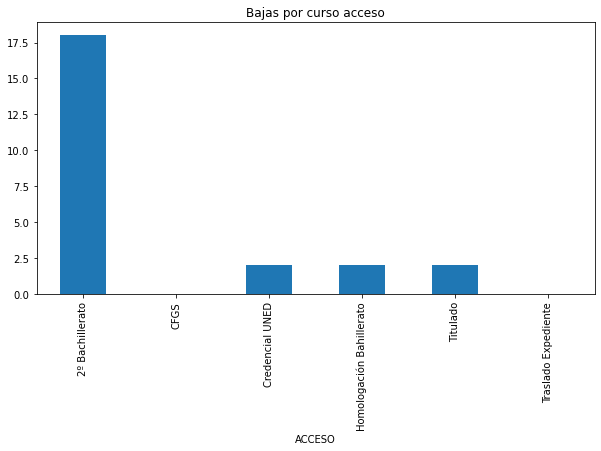

In [70]:
df.groupby('ACCESO')['baja'].sum().plot(kind='bar', figsize=(10,5), title='Bajas por curso acceso')

<AxesSubplot:title={'center':'Bajas por género'}, xlabel='SEXO'>

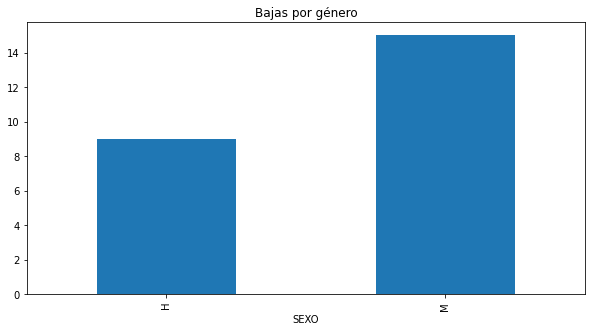

In [71]:
df.groupby('SEXO')['baja'].sum().plot(kind='bar', figsize=(10,5), title='Bajas por género')

<AxesSubplot:title={'center':'Bajas por curso académico'}, xlabel='CURSACAD_BAJA'>

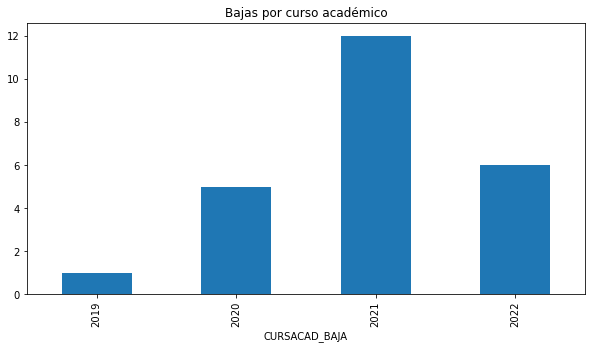

In [69]:
#plot month on x axis and count on y axis
df.groupby('CURSACAD_BAJA')['baja'].sum().plot(kind='bar', figsize=(10,5), title='Bajas por curso académico')

<AxesSubplot:title={'center':'Bajas por mes'}, xlabel='mes_origen'>

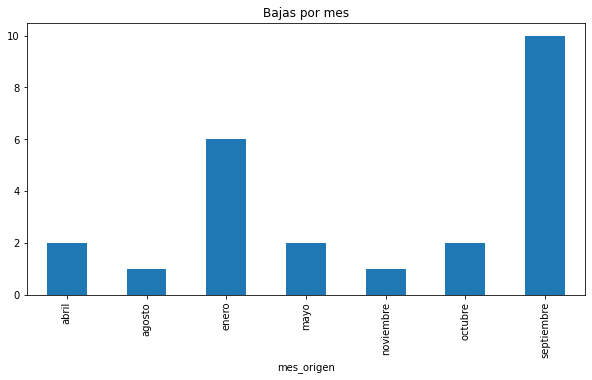

In [72]:
df.groupby('mes_origen')['baja'].sum().plot(kind='bar', figsize=(10,5), title='Bajas por mes')

<AxesSubplot:title={'center':'Bajas por curso acceso'}, xlabel='VC_CODPROV_HAB'>

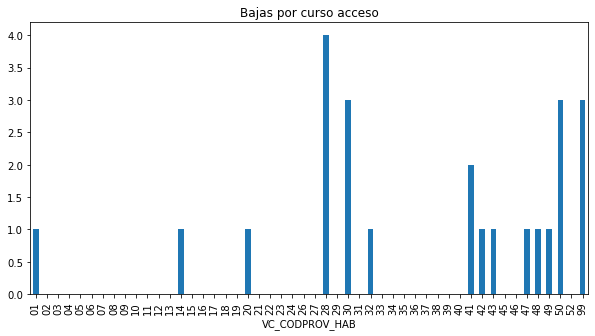

In [80]:
#si lo pintamos por provincia vemos que la mayoria son de Madrid 
df.groupby('VC_CODPROV_HAB')['baja'].sum().plot(kind='bar', figsize=(10,5), title='Bajas por curso acceso')

<AxesSubplot:title={'center':'Bajas por provincia'}>

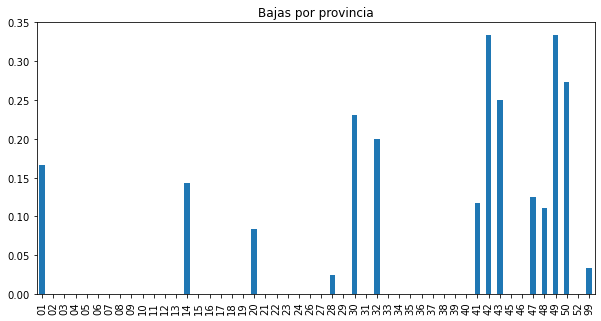

In [81]:
#sin embargo como la mayoria de los alumnos son de Madrid, vamos a ver el porcentaje de bajas por provincia
plot1= df.groupby('VC_CODPROV_HAB')['baja'].sum()/ df['VC_CODPROV_HAB'].value_counts()
plot1.plot(kind='bar', figsize=(10,5), title='Bajas por provincia')

In [ ]:
#comprobamos que efectivamente el mayor porcentaje de bajas no es Madrid si no de otras provincias 

## Análisis númerico

In [83]:
def Num_info(df, numeric_column):
    df_result = pd.DataFrame(columns=["columns","null_values","null_percent"])
    
    df_temp=pd.DataFrame()
    for value in numeric_column:
        df_temp["columns"] = [value]
        df_temp["null_values"] = df[value].isna().sum()
        df_temp["null_percent"] = (df[value].isna().sum()/len(df)*100).round(1)
        df_result = df_result.append(df_temp)
    
    df_result.sort_values("null_values", ascending =False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result

In [84]:
Num_info(df, numerical_col)

C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\3075763762.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\3075763762.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\3075763762.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23876\3075763762.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(df_temp)
C:\Users\eugeniogil\

,null_values,null_percent
columns,,
NB_EM_NOTA_PAU,386,72.4
NB_EM_NOTA_1BACHI,248,46.5
NB_NOTA_IDIOMA_ING,129,24.2
NB_NOTA_ESPECIFICA,99,18.6
NB_NOTA_PSICOTECNICO,82,15.4
NB_NOTAESTUDIOS,68,12.8
NOTA_ANATOMIA,25,4.7
NOTA_INMUNOLOGIA,25,4.7
NOTA_BIOETICA,25,4.7


<AxesSubplot:>

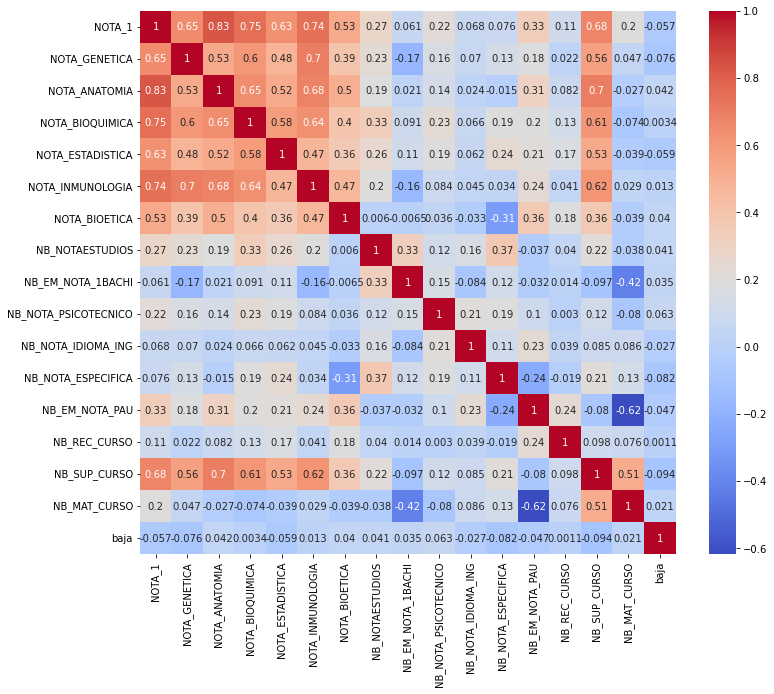

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(train_df.corr(), annot = True, cmap = 'coolwarm')

In [12]:
#tratamos los missings
print('El tamaño del dataset es: ' +str(train_df.shape))
'\n'
print( 'Hay missing \n' + str(train_df.isna().sum()/train_df.shape[0]))
percentage_missing = train_df.isna().sum()/train_df.shape[0]

El tamaño del dataset es: (532, 26)
Hay missing 
NIA                     0.000000
VC_CURSACAD_INI         0.000000
DT_BAJA                 0.956767
CURSACAD_BAJA           0.956767
NOTA_1                  0.000000
NOTA_GENETICA           0.041353
NOTA_ANATOMIA           0.046992
NOTA_BIOQUIMICA         0.041353
NOTA_ESTADISTICA        0.041353
NOTA_INMUNOLOGIA        0.046992
NOTA_BIOETICA           0.046992
NB_NOTAESTUDIOS         0.127820
NB_EM_NOTA_1BACHI       0.466165
NB_NOTA_PSICOTECNICO    0.154135
NB_NOTA_IDIOMA_ING      0.242481
NB_NOTA_ESPECIFICA      0.186090
NB_EM_NOTA_PAU          0.725564
SEXO                    0.000000
NACIONALIDAD            0.000000
VC_CODPROV_HAB          0.000000
ACCESO                  0.000000
F_NACIMIENTO            0.000000
NB_REC_CURSO            0.001880
NB_SUP_CURSO            0.001880
NB_MAT_CURSO            0.001880
baja                    0.000000
dtype: float64


array([[<AxesSubplot:title={'center':'DT_BAJA'}>,
        <AxesSubplot:title={'center':'NOTA_1'}>,
        <AxesSubplot:title={'center':'NOTA_GENETICA'}>,
        <AxesSubplot:title={'center':'NOTA_ANATOMIA'}>],
       [<AxesSubplot:title={'center':'NOTA_BIOQUIMICA'}>,
        <AxesSubplot:title={'center':'NOTA_ESTADISTICA'}>,
        <AxesSubplot:title={'center':'NOTA_INMUNOLOGIA'}>,
        <AxesSubplot:title={'center':'NOTA_BIOETICA'}>],
       [<AxesSubplot:title={'center':'NB_NOTAESTUDIOS'}>,
        <AxesSubplot:title={'center':'NB_EM_NOTA_1BACHI'}>,
        <AxesSubplot:title={'center':'NB_NOTA_PSICOTECNICO'}>,
        <AxesSubplot:title={'center':'NB_NOTA_IDIOMA_ING'}>],
       [<AxesSubplot:title={'center':'NB_NOTA_ESPECIFICA'}>,
        <AxesSubplot:title={'center':'NB_EM_NOTA_PAU'}>,
        <AxesSubplot:title={'center':'F_NACIMIENTO'}>,
        <AxesSubplot:title={'center':'NB_REC_CURSO'}>],
       [<AxesSubplot:title={'center':'NB_SUP_CURSO'}>,
        <AxesSubplot:title={

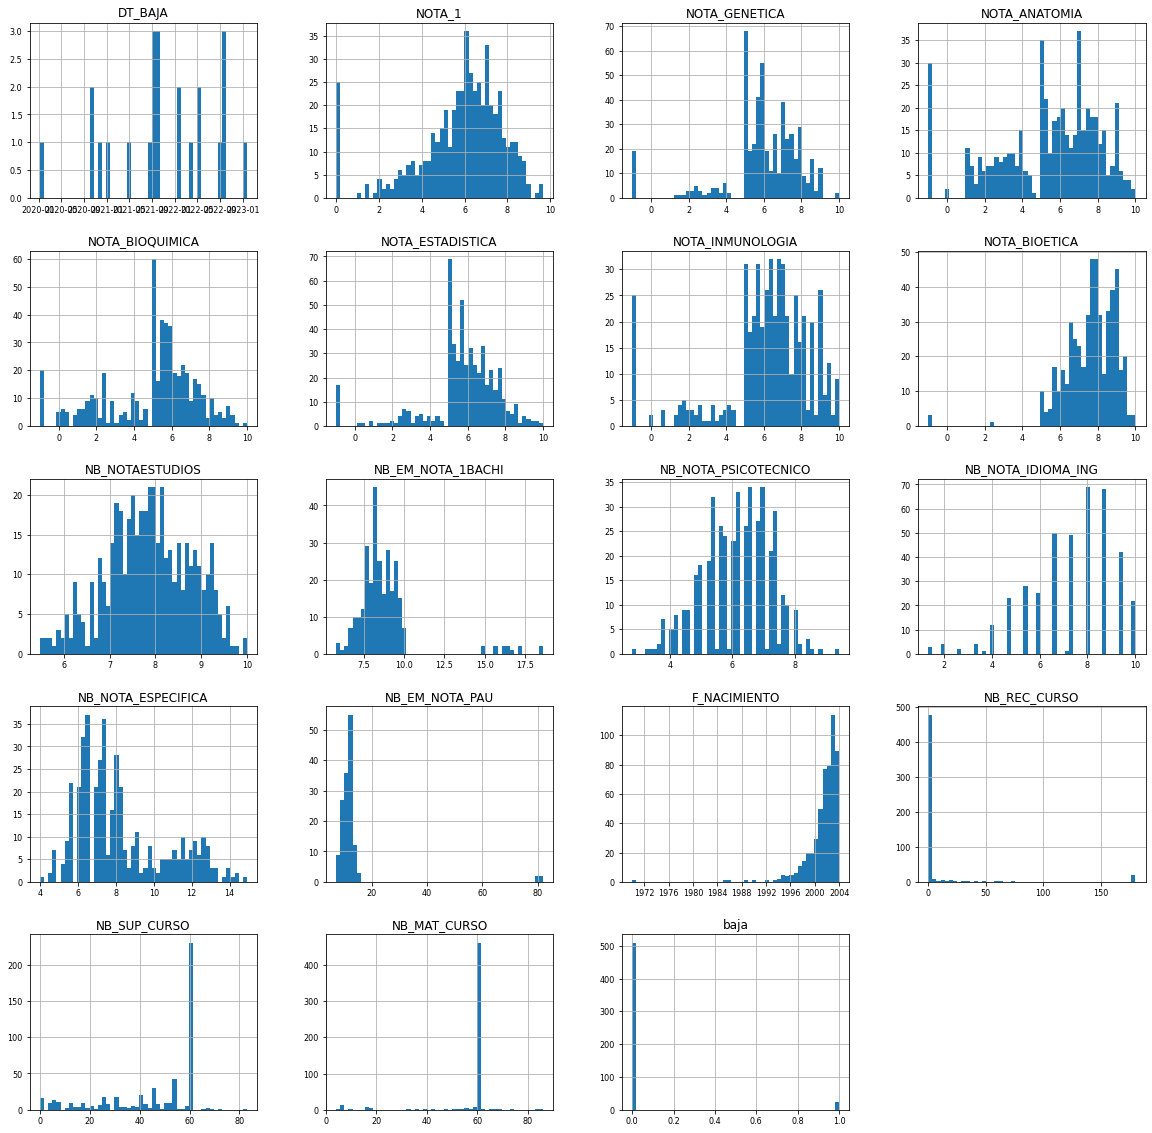

In [13]:
#histogram of all numeric variables
train_df.hist(figsize=(20,20), bins=50, xlabelsize=8, ylabelsize=8)

In [240]:
#count number of observations with NB_EM_NOTA_1BACHI above 10
print(train_df.shape)
print(train_df[train_df['NB_EM_NOTA_1BACHI'] > 10].shape)
print(train_df[train_df['NB_NOTA_ESPECIFICA'] > 14].shape)

(531, 26)
(13, 26)
(4, 26)


In [14]:
#marca los alumnos que quiera y dropealos por ese lado 
train_df['marca'] = np.where(train_df['NB_EM_NOTA_1BACHI'] > 10, 1, 0)
train_df['marca2'] = np.where(train_df['NB_NOTA_ESPECIFICA'] > 14, 1, 0)


In [15]:
#fuera alumnos con nota incorrecta
train_df = train_df[train_df['marca'] == 0]
train_df = train_df[train_df['marca2'] == 0]
#eliminamos la variable marca después de usarla
train_df = train_df.drop(['marca', 'marca2'], axis=1)

In [16]:
def transformations(df):
	#eliminamos duplicados que puedan entrar de la query
	df.drop_duplicates(subset=['NIA'], keep='first', inplace=True)
	#solo los alumnos que han aprobado el primer curso
	df=df[df['NOTA_1'] >= 5]
	#eliminamos las variables con más del 50% de los datos nulos
	percentage_missing = df.isna().sum()/df.shape[0]
	df.drop(columns=percentage_missing[percentage_missing>0.5].index, inplace=True)
	#la variable nota de estudios no tiene sentido que sea 0, por lo que la sustituimos por NaN
	df['NB_NOTAESTUDIOS'] = df['NB_NOTAESTUDIOS'].replace(0, np.nan)
	return df

#feature extraction 
def fe(df):
	#creamos la variable edad y la variable crédtios suspendidos
	df['ANIO_NACIMIENTO'] = df['F_NACIMIENTO'].dt.year
	df['edad'] = 2022 - df['ANIO_NACIMIENTO']
	df['CRED_SUS'] = df['NB_MAT_CURSO'] - df['NB_SUP_CURSO']
	return df

In [17]:
train_df = transformations(train_df)
df = transformations(df)

train_df = fe(train_df)
df = fe(df)

C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23316\2872620904.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=percentage_missing[percentage_missing>0.5].index, inplace=True)
C:\Users\eugeniogil\AppData\Local\Temp\ipykernel_23316\2872620904.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NB_NOTAESTUDIOS'] = df['NB_NOTAESTUDIOS'].replace(0, np.nan)


In [18]:
train_df['baja'].mean()

0.03380281690140845

In [19]:
train_df[train_df['baja']==1]

,NIA,VC_CURSACAD_INI,NOTA_1,NOTA_GENETICA,NOTA_ANATOMIA,NOTA_BIOQUIMICA,NOTA_ESTADISTICA,NOTA_INMUNOLOGIA,NOTA_BIOETICA,NB_NOTAESTUDIOS,NB_EM_NOTA_1BACHI,NB_NOTA_PSICOTECNICO,NB_NOTA_IDIOMA_ING,NB_NOTA_ESPECIFICA,SEXO,NACIONALIDAD,VC_CODPROV_HAB,ACCESO,F_NACIMIENTO,NB_REC_CURSO,NB_SUP_CURSO,NB_MAT_CURSO,baja,ANIO_NACIMIENTO,edad,CRED_SUS
1,640440,2019,6.773,5.0,7.5,5.7,5.9,6.0,8.8,7.71,NaN,7.0,7.33,6.00,H,E,30,2º Bachillerato,2001-11-19,0.0,60.0,60.0,1,2001,21,0.0
2,645603,2019,8.902,8.0,9.7,8.1,7.7,9.0,8.8,NaN,NaN,5.6,NaN,NaN,M,E,49,Titulado,1996-03-29,7.0,59.0,59.0,1,1996,26,0.0
5,642286,2019,5.553,5.0,5.3,5.0,5.5,5.5,7.6,NaN,NaN,7.2,9.33,NaN,H,E,99,Titulado,1996-07-15,180.0,54.0,60.0,1,1996,26,6.0
6,641876,2019,8.473,8.0,8.4,7.4,6.8,9.0,9.5,8.35,NaN,7.2,4.00,9.14,M,E,47,2º Bachillerato,2001-11-05,0.0,60.0,60.0,1,2001,21,0.0
7,649246,2020,8.472,7.3,9.5,8.4,5.9,9.8,8.6,7.57,NaN,7.6,7.33,7.14,H,E,30,2º Bachillerato,2001-12-06,0.0,60.0,60.0,1,2001,21,0.0
8,657431,2020,8.822,7.5,9.0,9.3,8.1,9.1,8.6,9.19,NaN,7.8,7.33,7.14,M,E,32,2º Bachillerato,2002-08-04,0.0,60.0,60.0,1,2002,20,0.0
10,649820,2020,7.063,6.1,7.0,6.7,6.3,8.1,8.3,8.07,8.00,5.8,6.00,8.57,H,E,14,2º Bachillerato,2002-08-21,0.0,60.0,60.0,1,2002,20,0.0
11,651824,2020,8.500,7.0,7.0,7.2,7.2,8.1,8.2,9.63,8.38,7.0,NaN,5.71,M,I,99,Credencial UNED,2002-11-05,0.0,6.0,16.0,1,2002,20,10.0
18,670734,2021,6.418,6.0,5.8,5.8,6.1,6.5,7.9,8.61,8.70,6.4,8.00,11.61,M,E,43,2º Bachillerato,2003-11-02,0.0,60.0,60.0,1,2003,19,0.0
19,640263,2019,6.170,8.0,7.2,5.5,3.6,7.1,7.6,6.78,NaN,8.0,8.67,7.43,H,E,50,2º Bachillerato,2001-07-13,0.0,53.0,60.0,1,2001,21,7.0


In [20]:
#split x and y
y = train_df['baja']
X = train_df.drop(columns=['baja', 'VC_CURSACAD_INI', 'F_NACIMIENTO', 'ANIO_NACIMIENTO', 'NIA'])

X.columns

Index(['NOTA_1', 'NOTA_GENETICA', 'NOTA_ANATOMIA', 'NOTA_BIOQUIMICA',
       'NOTA_ESTADISTICA', 'NOTA_INMUNOLOGIA', 'NOTA_BIOETICA',
       'NB_NOTAESTUDIOS', 'NB_EM_NOTA_1BACHI', 'NB_NOTA_PSICOTECNICO',
       'NB_NOTA_IDIOMA_ING', 'NB_NOTA_ESPECIFICA', 'SEXO', 'NACIONALIDAD',
       'VC_CODPROV_HAB', 'ACCESO', 'NB_REC_CURSO', 'NB_SUP_CURSO',
       'NB_MAT_CURSO', 'edad', 'CRED_SUS'],
      dtype='object')

<AxesSubplot:>

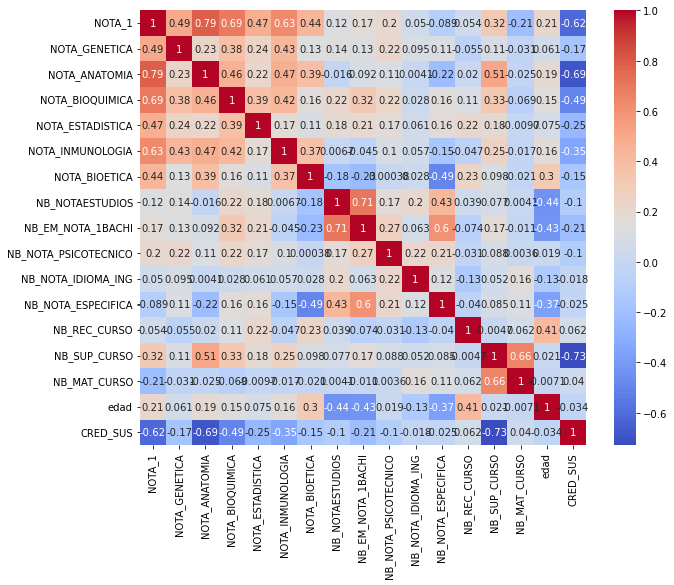

In [250]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(X.corr(), annot = True, cmap = 'coolwarm')


In [24]:
#para evitar violar la suposición de independencia de las variables, eliminamos las variables que tienen una corrlación mayor 0.76
X.drop(columns=['NB_SUP_CURSO'], inplace=True)

In [25]:
categorical_features = ['VC_CODPROV_HAB', 'SEXO', 'NACIONALIDAD', 'ACCESO']

#probamos a utilizar otro encoder donde la variable provincia va por su cuenta
#categorical_features = ['SEXO', 'NACIONALIDAD', 'ACCESO']
continuous_features = list(set(X.columns)-set(categorical_features))
#provincias = ['VC_CODPROV_HAB']

In [26]:
X.shape

(355, 20)

-------------------------------

### Missing data section

In [254]:
#section dedicated to missing values
#dataframe with only continuous features
X_cont = X[continuous_features]

In [255]:
X_cont.isnull().mean().sort_values(ascending=False)

NB_EM_NOTA_1BACHI       0.484419
NB_NOTA_IDIOMA_ING      0.195467
NB_NOTA_ESPECIFICA      0.155807
NB_NOTA_PSICOTECNICO    0.116147
NB_NOTAESTUDIOS         0.104816
NOTA_INMUNOLOGIA        0.002833
NOTA_BIOETICA           0.002833
NOTA_ANATOMIA           0.002833
NOTA_GENETICA           0.002833
NOTA_ESTADISTICA        0.002833
NOTA_BIOQUIMICA         0.002833
NB_REC_CURSO            0.000000
NB_MAT_CURSO            0.000000
edad                    0.000000
NOTA_1                  0.000000
CRED_SUS                0.000000
dtype: float64

<AxesSubplot:>

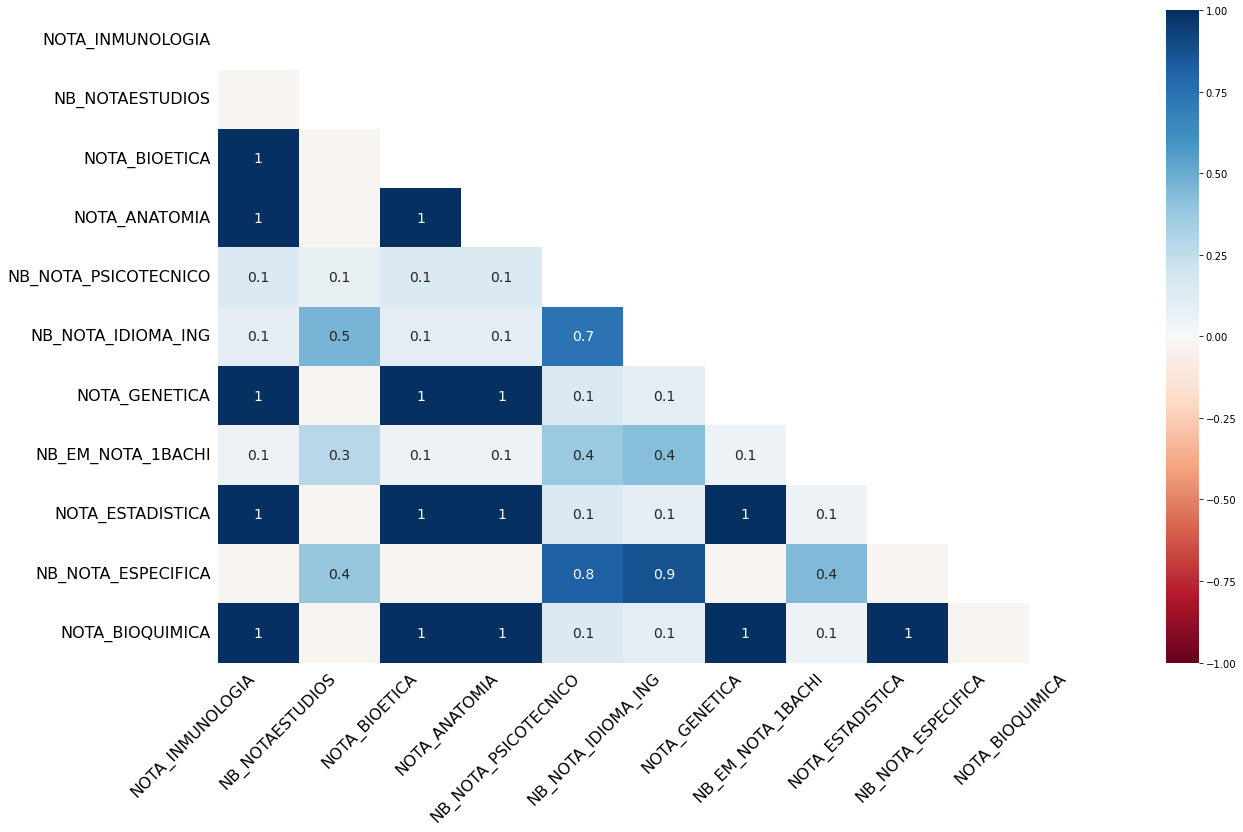

In [256]:
#!pip install missingno
import missingno as msno  

# Plot correlation heatmap of missingness
msno.heatmap(X_cont)

Podemos ver por las correlaciones que los datos missing son MNAR es decir no aleatorios. Esto crea un problema a la hora de imputarlos ya que pueden mostrar una correlación con un factor no observable. 

In [138]:
#realizamos un approach completo con KNN
from sklearn.impute import KNNImputer

# Copy the data
X_cont_imputed = X_cont.copy(deep=True)

# Init the transformer
knn_imp = KNNImputer(n_neighbors=3)

# Fit/transform
X_cont_imputed.loc[:, :] = knn_imp.fit_transform(X_cont_imputed)

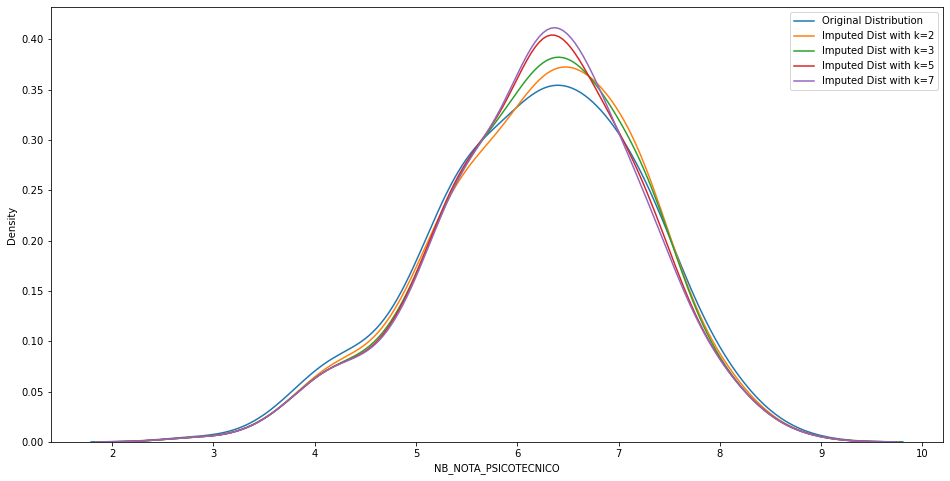

In [139]:
#como no podemos ajustar el modelo lo hacemos de manera visual
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(X_cont.NB_NOTA_PSICOTECNICO, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    X_cont_imputed.loc[:, :] = knn_imp.fit_transform(X_cont)
    sns.kdeplot(X_cont_imputed.NB_NOTA_PSICOTECNICO, label=f"Imputed Dist with k={k}")

plt.legend()

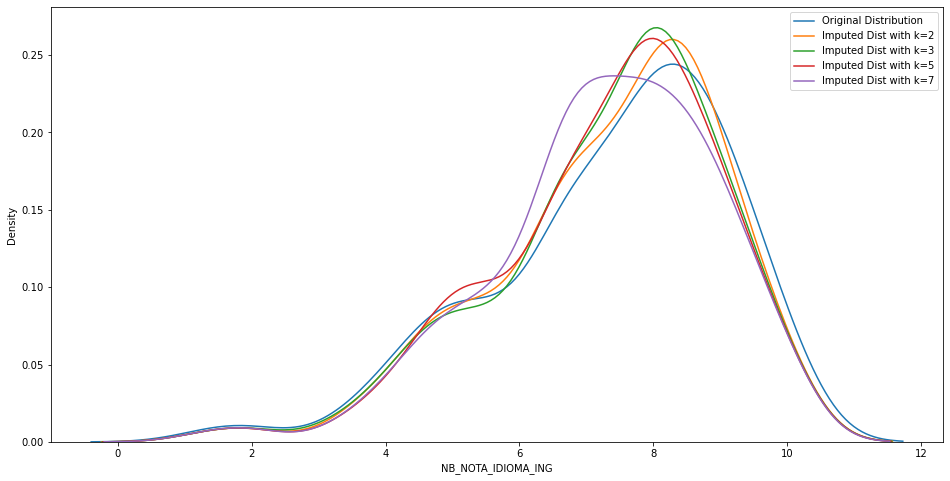

In [140]:
#como no podemos ajustar el modelo lo hacemos de manera visual
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(X_cont.NB_NOTA_IDIOMA_ING, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    X_cont_imputed.loc[:, :] = knn_imp.fit_transform(X_cont)
    sns.kdeplot(X_cont_imputed.NB_NOTA_IDIOMA_ING, label=f"Imputed Dist with k={k}")

plt.legend()

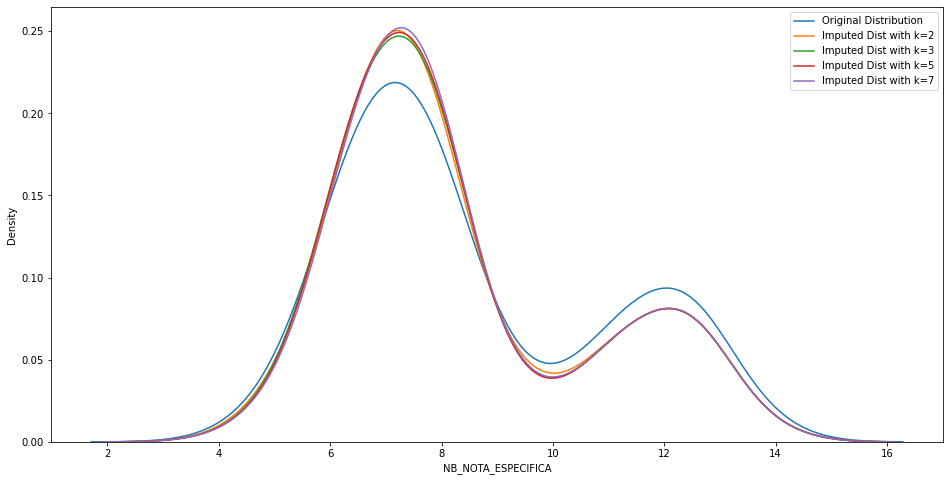

In [141]:
#como no podemos ajustar el modelo lo hacemos de manera visual
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(X_cont.NB_NOTA_ESPECIFICA, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    X_cont_imputed.loc[:, :] = knn_imp.fit_transform(X_cont)
    sns.kdeplot(X_cont_imputed.NB_NOTA_ESPECIFICA, label=f"Imputed Dist with k={k}")

plt.legend()

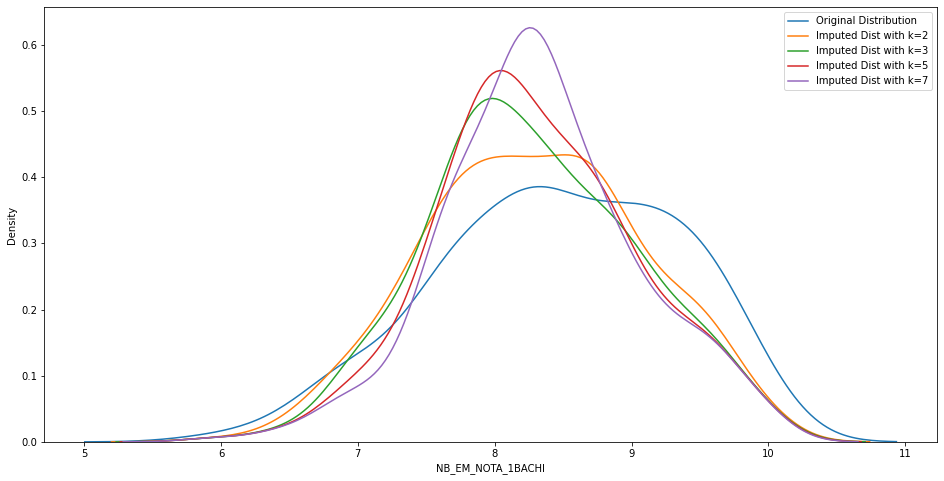

In [142]:
#como no podemos ajustar el modelo lo hacemos de manera visual
n_neighbors = [2, 3, 5, 7]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sns.kdeplot(X_cont.NB_EM_NOTA_1BACHI, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    X_cont_imputed.loc[:, :] = knn_imp.fit_transform(X_cont)
    sns.kdeplot(X_cont_imputed.NB_EM_NOTA_1BACHI, label=f"Imputed Dist with k={k}")

plt.legend()

Podemos ver que cada variable tiene diferentes clusters recomendados, voy a utilizar un imputador computacionalemnte más eficiente que el KNN.
A regressor is passed to the transformer. <br>
The first feature (feature_1) with missing values is chosen. <br>
The data is split into train/test sets where the train set contains all the known values for feature_1, and the test set contains the missing samples. <br>
The regressor is fit on all the other variables as inputs and with feature_1 as an output. <br>
The regressor predicts the missing values. <br>
The transformer continues this process until all features are imputed. <br>
Steps 1–6 are called a single iteration round, and these steps are carried out multiple times as specified by the max_iter transformer parameter. <br>
Este método es aún experimental, pero presenta los mejores resultados basandose en la literatura. 

--------------------------------------------------

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [28]:
#guardo el x_train para poder ver despúes la importancia de las variables
X_train2 = X_train.copy()

In [29]:

#Pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder


continuous_pipeline = Pipeline(steps = [
    ('imputation', KNNImputer(n_neighbors=2)),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps = [
    ('imputation', SimpleImputer(strategy='most_frequent')),
    #sparse output a 0 para tener un np array
    #dropeamos una columna binaria para evitar la multicolinealidad
    #('codification', OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'first'))
    ('codification', TargetEncoder())
])

preprocessing_pipeline = ColumnTransformer(transformers = [
        ('continuous', continuous_pipeline, continuous_features),
        ('categorical', categorical_pipeline, categorical_features)
    ],
    remainder = 'drop' 
)

steps = [('preprocessing', preprocessing_pipeline)]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

###transformation function 

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

from sklearn import set_config
set_config(display="diagram")
pipeline


c:\Users\eugeniogil\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\eugeniogil\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
c:\Users\eugeniogil\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\eugeniogil\Anaconda3\lib\site-packages\catego

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('imputation',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['NOTA_ANATOMIA', 'CRED_SUS',
                                                   'NB_NOTAESTUDIOS', 'edad',
                                                   'NOTA_ESTADISTICA',
                                                   'NB_NOTA_ESPECIFICA',
                                                   'NB_MAT_CURSO', 'NOTA_1',
                                                   'NB_REC_CURSO',
                                                   'NOTA_INMUNOLOGIA',
                                                   'NOTA_BIOQUIMICA',
                                                   'NB_NOTA_PSICOTECNICO',
                                                   'NOTA_GENETICA',
                                                   'NOTA_BIOETICA',
                                                   'NB_NOTA_IDIOMA_ING',
                                                   'NB_EM_NOTA_1BACHI']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('codification',
                                                                   TargetEncoder())]),
                                                  ['VC_CODPROV_HAB', 'SEXO',
                                                   'NACIONALIDAD',
                                                   'ACCESO'])]))])

In [146]:
#grid search to look for the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

lr = linear_model.LogisticRegression(random_state= 42, solver = 'liblinear')

C = [1,2,3,4,5,6]
penalty  = ['l1', 'l2']
solvers = ['liblinear', 'saga', 'newton-cg']

parameters = dict(C=C, penalty=penalty, solver = solvers)

GS = GridSearchCV(lr, parameters, cv=3, verbose=0)
GS.fit(X_train, y_train)

print('Best Penalty:', GS.best_estimator_.get_params()['penalty'])
print('Best C:', GS.best_estimator_.get_params()['C'])
print(); print(GS.best_estimator_.get_params())


c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: Con

Best Penalty: l1
Best C: 3

{'C': 3, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\eugeniogil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: Con

In [260]:
#implementamos la regresión logística
from sklearn.model_selection import cross_val_score, train_test_split

lr = linear_model.LogisticRegression(random_state=42, C = 3, penalty = 'l1', solver = 'liblinear')
lr.fit(X_train, y_train)

LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

In [261]:
print(lr.score(X_test, y_test))

0.9550561797752809


In [262]:
from sklearn.metrics import confusion_matrix, classification_report
y_predict = lr.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        85
           1       0.50      0.25      0.33         4

    accuracy                           0.96        89
   macro avg       0.73      0.62      0.66        89
weighted avg       0.94      0.96      0.95        89



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

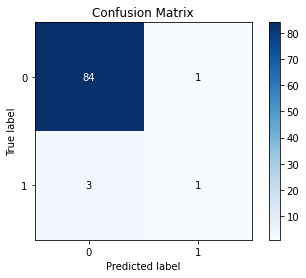

In [263]:
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(y_test, y_predict)

In [264]:
#regresión logística
y_proba = lr.predict_proba(X_test)[:,1]

df_proba = pd.DataFrame(y_proba, columns=['probabilidad'])
df_label = pd.DataFrame(y_test, columns=['label'])

results = pd.concat([df_proba, df_label], axis=1)

In [265]:
def score(mod, X_test, y_test, alarm = None):
    if not alarm:
        alarm = sum(y_test == 1)/len(y_test)
    y_pred_prob = mod.predict_proba(X_test)[:,1]
    resultados = pd.DataFrame({'Prob':y_pred_prob, 'Label':y_test})
    resultados.sort_values('Prob', axis=0, ascending=False, inplace=True)
    resultados.reset_index(inplace=True)
    alarmas = int(alarm*len(y_test))
    print('Casos Analizados:{}'.format(len(y_test)))
    print('Alarmas:{}'.format(alarmas))
    print('Cazados:{}'.format(sum(resultados[0:alarmas].Label==1)))
    print('Total de bajas en el conjunto:{}'.format(sum(resultados.Label == 1)))
    return

In [266]:
score(lr, X_test, y_test, alarm = 0.25)

Casos Analizados:89
Alarmas:22
Cazados:2
Total de bajas en el conjunto:4


In [267]:
score(lr, X_test, y_test, alarm = 0.20)

Casos Analizados:89
Alarmas:17
Cazados:2
Total de bajas en el conjunto:4


In [ ]:

#query ejemplo 2021
c = conn.cursor()
query = c.execute('''
select * from (
select distinct a.nia, a.vc_cursacad_ini, a.dt_baja , cursacad_baja, dsc.nota_1, gen.nota_genetica, ana.nota_anatomia, bio.nota_bioquimica, esta.nota_estadistica, inmu.nota_inmunologia, etica.nota_bioetica,
nb_notaestudios, nb_em_nota_1bachi, nb_nota_psicotecnico,nb_nota_idioma_ing, nb_nota_especifica, sexo, nacionalidad, vc_codprov_hab, acceso, f_nacimiento, dsc.nb_rec_curso, dsc.nb_sup_curso, dsc.nb_mat_curso
from dv_perfil_alumno a
    left join (
        select nia, vc_cursacad, nota_media_curso_ss nota_1, nb_rec_curso, nb_sup_curso, nb_mat_curso
            from ds_resumen_creditos
            ) dsc on dsc.nia = a.nia and dsc.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_genetica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130105'
        order by 1
        ) gen on gen.nia = a.nia and gen.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_anatomia
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130101'
        order by 1
        ) ana on ana.nia = a.nia and ana.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_bioquimica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130103'
        order by 1
        ) bio on bio.nia = a.nia and bio.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_estadistica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130104'
        order by 1
        ) esta on esta.nia = a.nia and esta.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_inmunologia
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130109'
        order by 1
        ) inmu on inmu.nia = a.nia and inmu.vc_cursacad = a.vc_cursacad_ini
    left join (
        select distinct  vc_cursacad, nia, a.vc_codasig, b.vc_desasig, nvl(a.nb_nota_3,nvl(a.nb_nota_2,a.nb_nota_1)) as Nota_bioetica
        from mat_asignaturas a
        inner join odo_asignaturas b on b.vc_codasig = a.vc_codasig 
        where a.vc_codasig like '%01%' and a.vc_codasig = '0130106'
        order by 1
        ) etica on etica.nia = a.nia and etica.vc_cursacad = a.vc_cursacad_ini
where a.vc_cursacad_ini =2021 and a.vc_codcarr = 'GME' and (to_number(to_char(a.dt_baja, 'YYYY')) <> a.vc_cursacad or dt_baja is null)
order by 2,1,4
 ) sub1 order by 3 asc
 ''')

df = pd.DataFrame(c.fetchall(), columns = [i[0] for i in c.description])

In [268]:
# iterate from 0.1 to 0.50 every 0.01
variable = np.arange(0.1, 0.50, 0.02)
# create empty list to store results
resultados = []
# loop over the different values of the variable
for i in variable:
    resultados.append(score(lr, X_test, y_test, alarm = i))

Casos Analizados:89
Alarmas:8
Cazados:1
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:10
Cazados:1
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:12
Cazados:1
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:14
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:16
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:17
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:19
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:21
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:23
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:24
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:26
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:28
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:30
Cazados:2
Total de bajas en el conjunto:4
Casos Analizados:89
Alarmas:32
Cazados:2
Total de ba

### Vamos a ver los pesos asignados a cada variable actualmente utilizados por el modelo

In [269]:
#number of features seen during fit
lr.n_features_in_

20

In [270]:
lr.get_params()

{'C': 3,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Nota targetEncoder
This paper presents a simple preprocessing scheme for high-cardinality categorical data that allows this class of attributes to be used in predictive models such as neural networks, linear and logistic regression. The proposed method is based on a well-established statistical method (empirical Bayes) that is straightforward to implement as an in-database procedure. Furthermore, for categorical attributes with an inherent hierarchical structure, like ZIP codes, the preprocessing scheme can directly leverage the hierarchy by blending statistics at the various levels of aggregation.

En este notebook, utilizaremos el método de target encoder. En el caso de problemas de clasificación binaria, el método de target encoder reemplaza con una media ponderada de la probabilidad de ver el target 1 cuando la variable toma cierta categoría y la probabilidad del target sobre todo el dataset (prior). Para más detalles, ver este artículo.

Se suele utilizar cuando la variable categórica tiene muy alta dimensionalidad. Tiene la ventaja de que no aumenta la dimensionalidad del dataset, pero el inconveniente de que la variable deja de ser fácilmente interpretable ya que es sustituida por un valor continuo.
Se encuentra implementado en category_encoders.
El peso de la prior de la clase positiva en el dataset global respecto a la prior de la clase positiva en cada categoría se especifica mediante el parámetro smoothing.
Para que la prior de la categoría sea tenida en cuenta en la media ponderada debe tener un mínimo número de muestras especificadas en el parámetro min_samples_leaf.

In [273]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_train2.columns.tolist())

Weight,Feature
0.0180 ± 0.0180,NB_NOTA_IDIOMA_ING
0.0022 ± 0.0090,NB_NOTAESTUDIOS
0.0022 ± 0.0090,VC_CODPROV_HAB
0.0022 ± 0.0090,NACIONALIDAD
0 ± 0.0000,CRED_SUS
0 ± 0.0000,NOTA_GENETICA
0 ± 0.0000,NOTA_ANATOMIA
0 ± 0.0000,NOTA_BIOQUIMICA
0 ± 0.0000,NOTA_ESTADISTICA
0 ± 0.0000,NOTA_INMUNOLOGIA


In [ ]:
#sin embargo está comprobado que los resultados obtenidosp por la permutación de las variables no son fiables con un data set desbalanceado
#es mejor utilizar el coeficiente de la regresión logística

import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

## Ejemplo del modelo en producción con el año 2021

In [205]:
df[df['baja']== 1]

,NIA,VC_CURSACAD_INI,NOTA_1,NOTA_GENETICA,NOTA_ANATOMIA,NOTA_BIOQUIMICA,NOTA_ESTADISTICA,NOTA_INMUNOLOGIA,NOTA_BIOETICA,NB_NOTAESTUDIOS,NB_EM_NOTA_1BACHI,NB_NOTA_PSICOTECNICO,NB_NOTA_IDIOMA_ING,NB_NOTA_ESPECIFICA,SEXO,NACIONALIDAD,VC_CODPROV_HAB,ACCESO,F_NACIMIENTO,NB_REC_CURSO,NB_SUP_CURSO,NB_MAT_CURSO,baja,ANIO_NACIMIENTO,edad,CRED_SUS
3,670734,2021,6.418,6.0,5.8,5.8,6.1,6.5,7.9,8.61,8.7,6.4,8.0,11.61,M,E,43,2º Bachillerato,2003-11-02,0,60,60,1,2003,19,0


In [206]:
def pipeline_f(X):
    X_tra = pipeline.transform(X)
    return X_tra

def lr_proba(X):
    probas = lr.predict_proba(X)[:,1]
    return probas

In [207]:
df.shape

(133, 26)

In [208]:
NIA = df[['NIA']]
X = df.drop(columns=['baja', 'VC_CURSACAD_INI', 'F_NACIMIENTO', 'ANIO_NACIMIENTO', 'NIA'])

In [209]:
o = pipeline_f(X)
fitted = lr_proba(o)

In [210]:
def final_transformation(objecto):
    df_probas = pd.DataFrame(objecto, columns=['probabilidad'])
    df_probas['top_25'] = df_probas.probabilidad  > df_probas.probabilidad.quantile(0.66)
    return df_probas

In [211]:
final_df = final_transformation(fitted)

In [212]:
final_df.shape

(133, 2)

In [213]:
final_df.sort_values(by= 'probabilidad', ascending=False)

,probabilidad,top_25
0,0.325339,True
46,0.312076,True
59,0.244285,True
129,0.232179,True
72,0.184497,True
...,...,...
122,0.000054,False
109,0.000052,False
4,0.000033,False
54,0.000031,False


In [214]:
NIA.reset_index(drop=True, inplace=True)

In [215]:
final_df1 = pd.concat([NIA, final_df], axis=1)

In [216]:
final_df1[final_df1['NIA'] == '670734']

,NIA,probabilidad,top_25
0,670734,0.325339,True


El modelo funciona peor cuando corregimos los datos para que no violen las assumptions de la regresión logística.